In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import fm2p

Loading DLC 2.3.7...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


c:\Users\dmartins\anaconda3\envs\fm1\lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [3]:
cfg = r'K:\Mini2P\250220_DMM_DMM042_pillar\preprocessed_config.yaml'
rname = 'fm1'

if type(cfg)==str:
    with open(cfg, 'r') as infile:
        cfg = yaml.load(infile, Loader=yaml.FullLoader)
rcfg = cfg[rname]

rpath = rcfg['rpath']
eye_data = fm2p.read_h5(rcfg['eye_preproc_path'])
top_data = fm2p.read_h5(rcfg['top_preproc_path'])
twop_data = fm2p.read_h5(rcfg['twop_preproc_path'])
eyeT_startInd = rcfg['eyeT_startInd']
eyeT_endInd = rcfg['eyeT_endInd']

# Two photon data
sps = twop_data['s2p_spks']
raw_dFF = twop_data['raw_dFF']
twop_dt = 1./cfg['twop_rate']
twopT = np.arange(0, np.size(sps, 1)*twop_dt, twop_dt)

# Eyecam data
eyeT = eye_data['eyeT'][eyeT_startInd:eyeT_endInd]
theta_raw = eye_data['theta'][eyeT_startInd:eyeT_endInd]
phi_raw = eye_data['phi'][eyeT_startInd:eyeT_endInd]
puprad_raw = eye_data['longaxis'][eyeT_startInd:eyeT_endInd]

# Interpolate eyecam data to twop and topdown data
eyeT = eyeT.copy() - eyeT[0]

theta = fm2p.interpT(theta_raw, eyeT, twopT, fill_consecutive=True)
phi = fm2p.interpT(phi_raw, eyeT, twopT, fill_consecutive=True)
puprad = fm2p.interpT(puprad_raw, eyeT, twopT, fill_consecutive=True)

# Topcam data
pxls2cm = top_data['pxls2cm']
speed = top_data['speed']
# Animal yaw is defined so that 0 deg is rightward in the raw video, 90 deg is downward in the raw
# video, and angles wrap from 0 to 360 deg clockwise.
yaw = top_data['head_yaw_deg']
movement_yaw = top_data['movement_yaw_deg']
top_x = top_data['x']
top_y = top_data['y']
top_xdisp = top_data['x_displacement']
top_ydisp = top_data['y_displacement']
arenaTL = (top_data['arenaTL']['x'], top_data['arenaTL']['y'])
arenaTR = (top_data['arenaTR']['x'], top_data['arenaTR']['y'])
arenaBL = (top_data['arenaBL']['x'], top_data['arenaBL']['y'])
arenaBR = (top_data['arenaBR']['x'], top_data['arenaBR']['y'])
pillarT = (top_data['pillarT']['x'], top_data['pillarT']['y'])
pillarB = (top_data['pillarB']['x'], top_data['pillarB']['y'])
pillarL = (top_data['pillarL']['x'], top_data['pillarL']['y'])
pillarR = (top_data['pillarR']['x'], top_data['pillarR']['y'])
pillar_radius = top_data['pillar_radius']
pillar_centroid = (top_data['pillar_centroid']['x'], top_data['pillar_centroid']['y'])

In [117]:
raw_dFF.shape

(368, 30000)

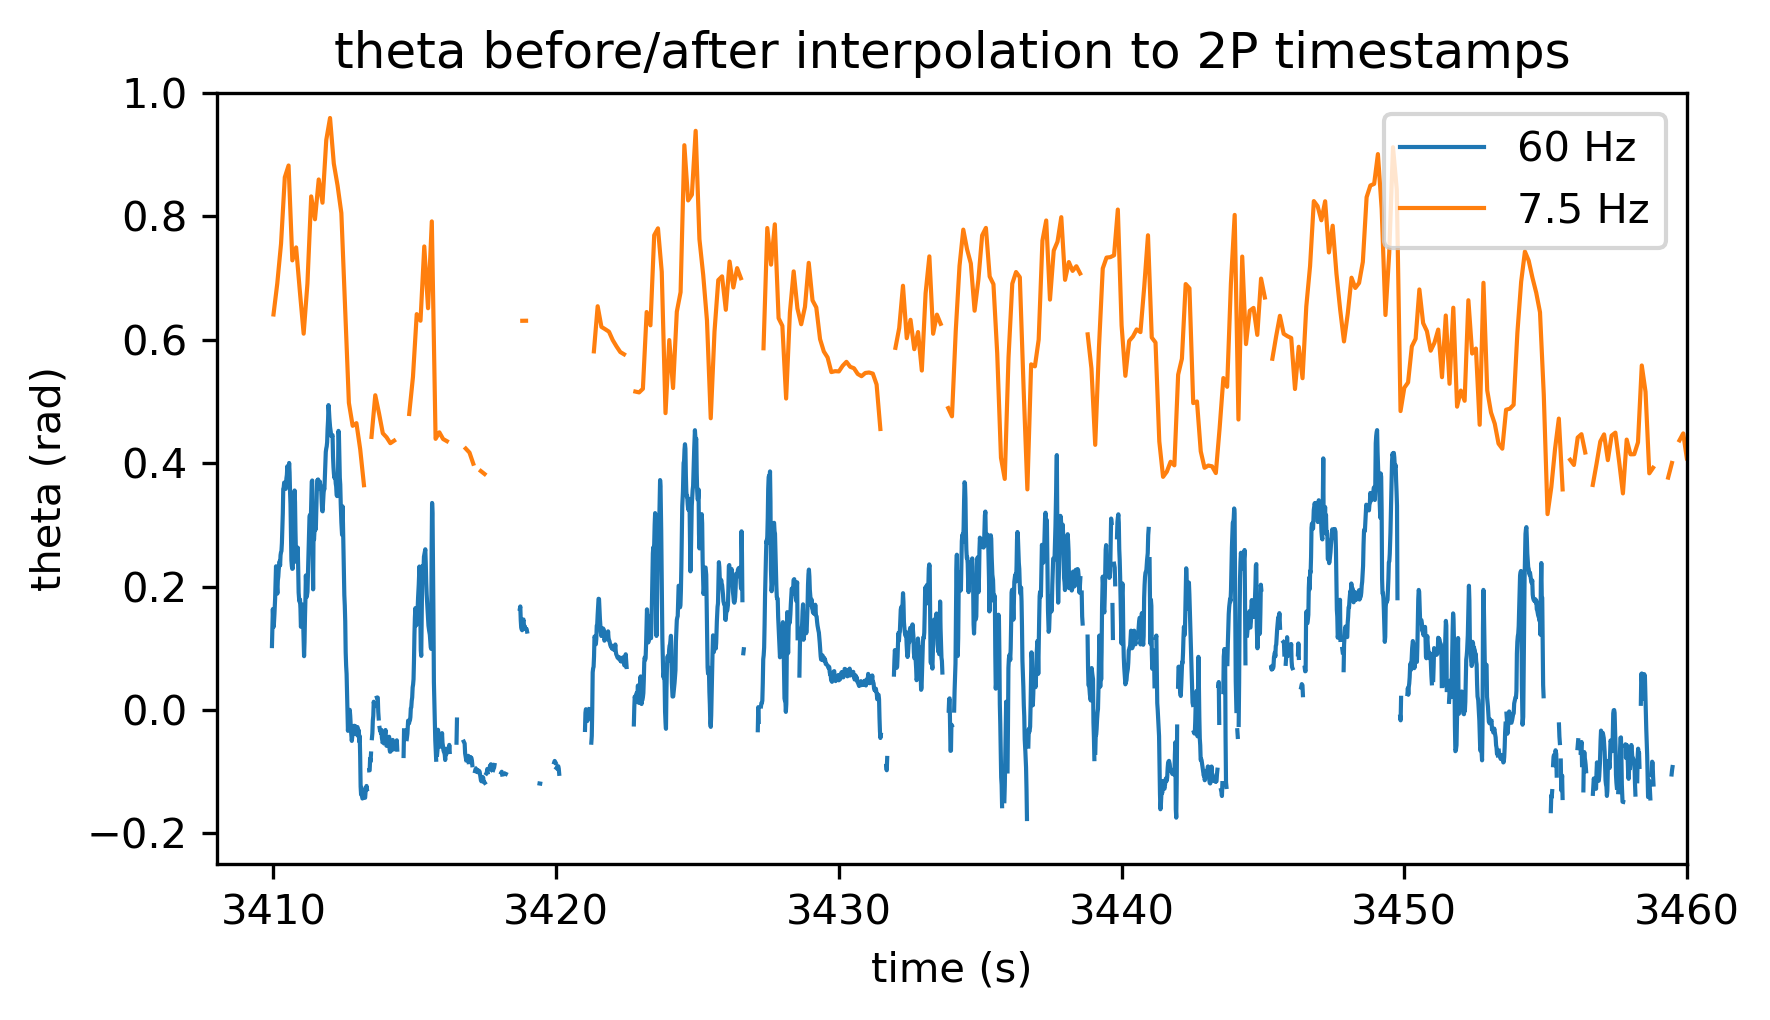

In [17]:
plt.figure(dpi=300, figsize=(6,3.5))
plt.plot(eyeT, theta_raw, lw=1, label='60 Hz')
plt.plot(twopT, theta+0.5, lw=1, label='7.5 Hz')
plt.xlim([3408, 3460])
plt.ylim([-.25,1])
plt.legend(loc='upper right')
plt.xlabel('time (s)')
plt.ylabel('theta (rad)')
plt.title('theta before/after interpolation to 2P timestamps')
plt.tight_layout()

In [20]:
dist_to_pillar = np.zeros_like(top_x) * np.nan
angle_to_pillar = np.zeros_like(top_x) * np.nan
angle_pillar_spans = np.zeros_like(top_x) * np.nan
for f in range(len(top_x)):

    # All geometry is handled using units of radians for angles and units of pixels for distances

    a_ = pillar_centroid[1] - top_y[f]
    b_ = pillar_centroid[0] - top_x[f]

    dist_to_pillar[f] = np.sqrt(b_**2 + a_**2)
    angle_to_pillar[f] = np.tan(a_ / b_) # rad
    
    # Angle that pillar spans given the animal's current distance
    angle_pillar_spans[f] = np.tan(pillar_radius / dist_to_pillar[f]) # rad

    # Horizontal gaze angle relative to the animal's head (instead of relative to the central axis
    # of the camera).
    theta_reltohead = theta[f] + cfg['eyecam_angular_offset']

In [40]:
twopT[-1]/60

66.66444444444444

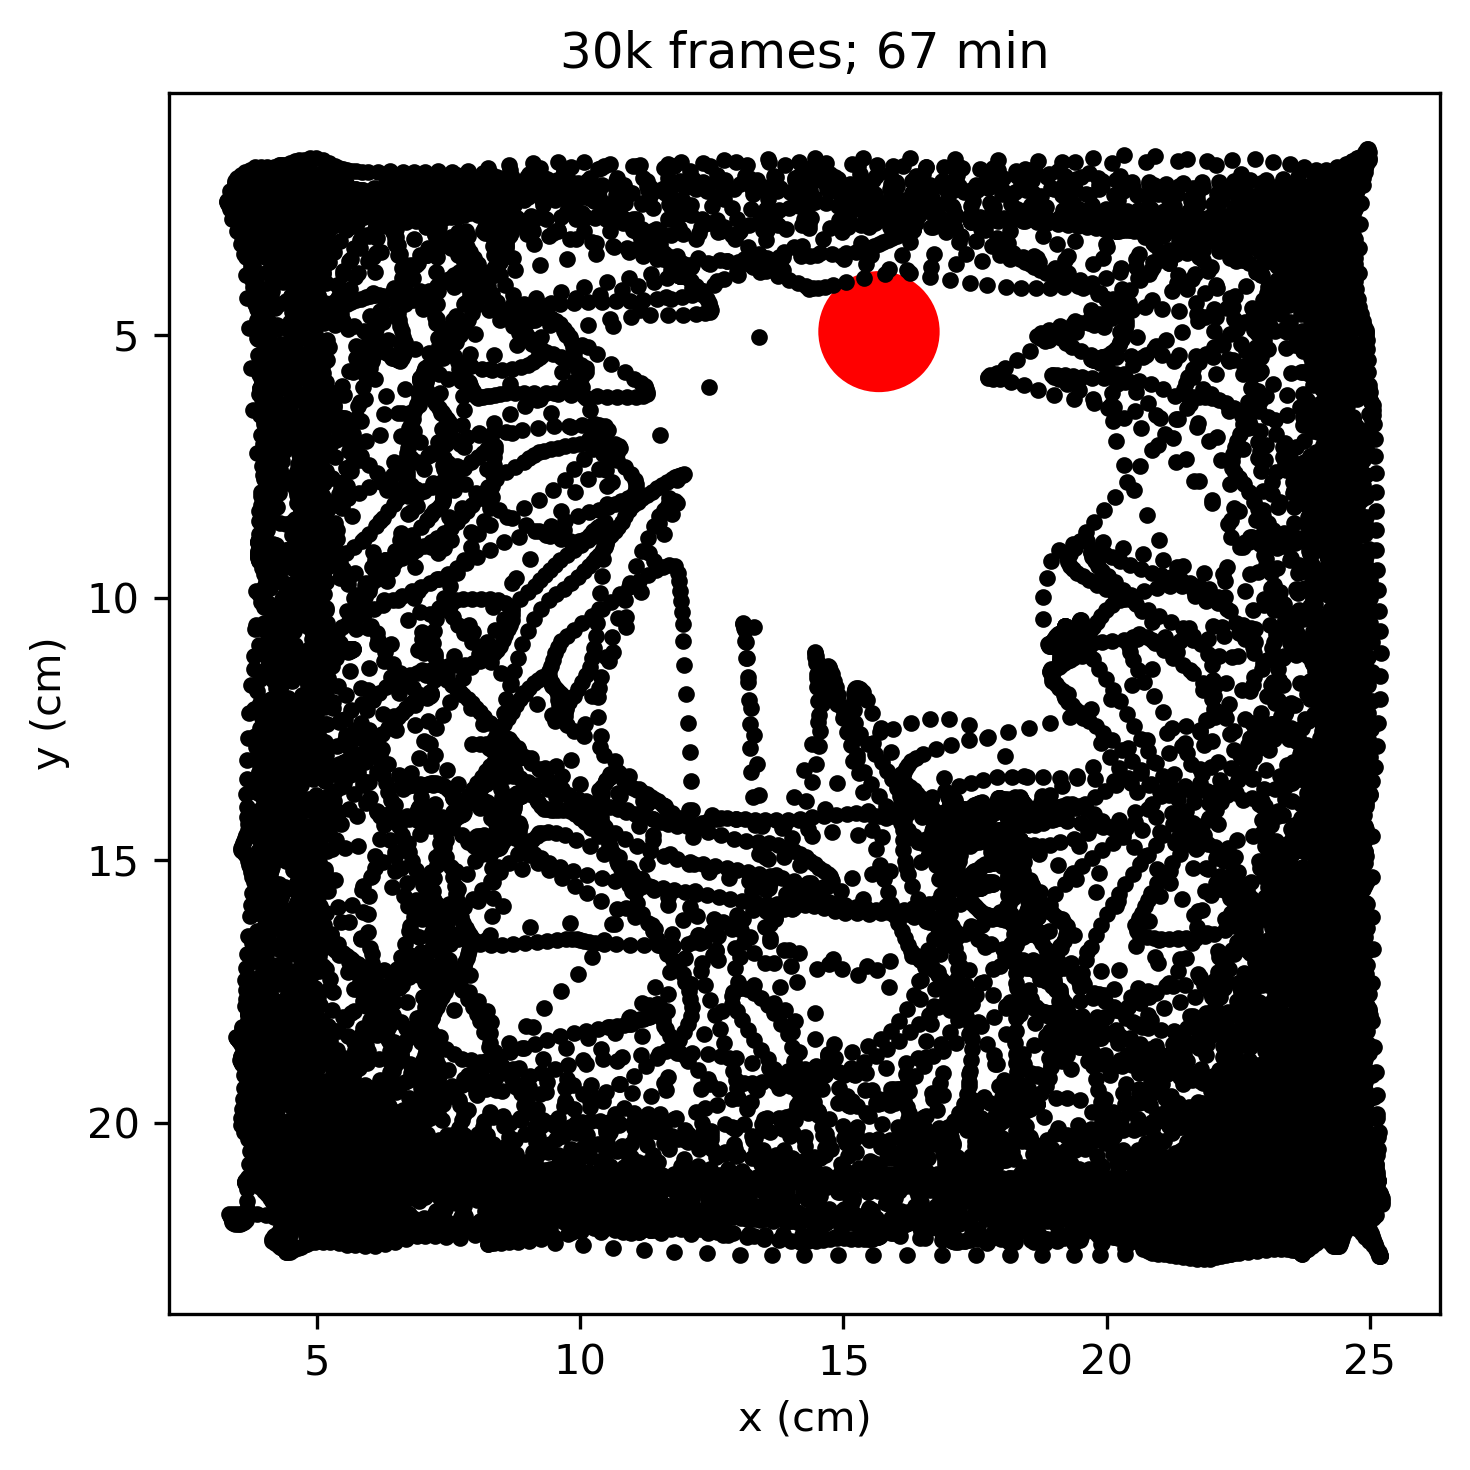

In [48]:
circle1 = plt.Circle(pillar_centroid/pxls2cm, pillar_radius/pxls2cm, color='r')

fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=300)
ax.invert_yaxis()
ax.plot(top_x/pxls2cm, top_y/pxls2cm, '.', color='k')
ax.add_patch(circle1)
ax.set_title('30k frames; 67 min')
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
fig.tight_layout()

In [101]:
def frac_good(x):
    return np.sum(~np.isnan(x)) / len(x)

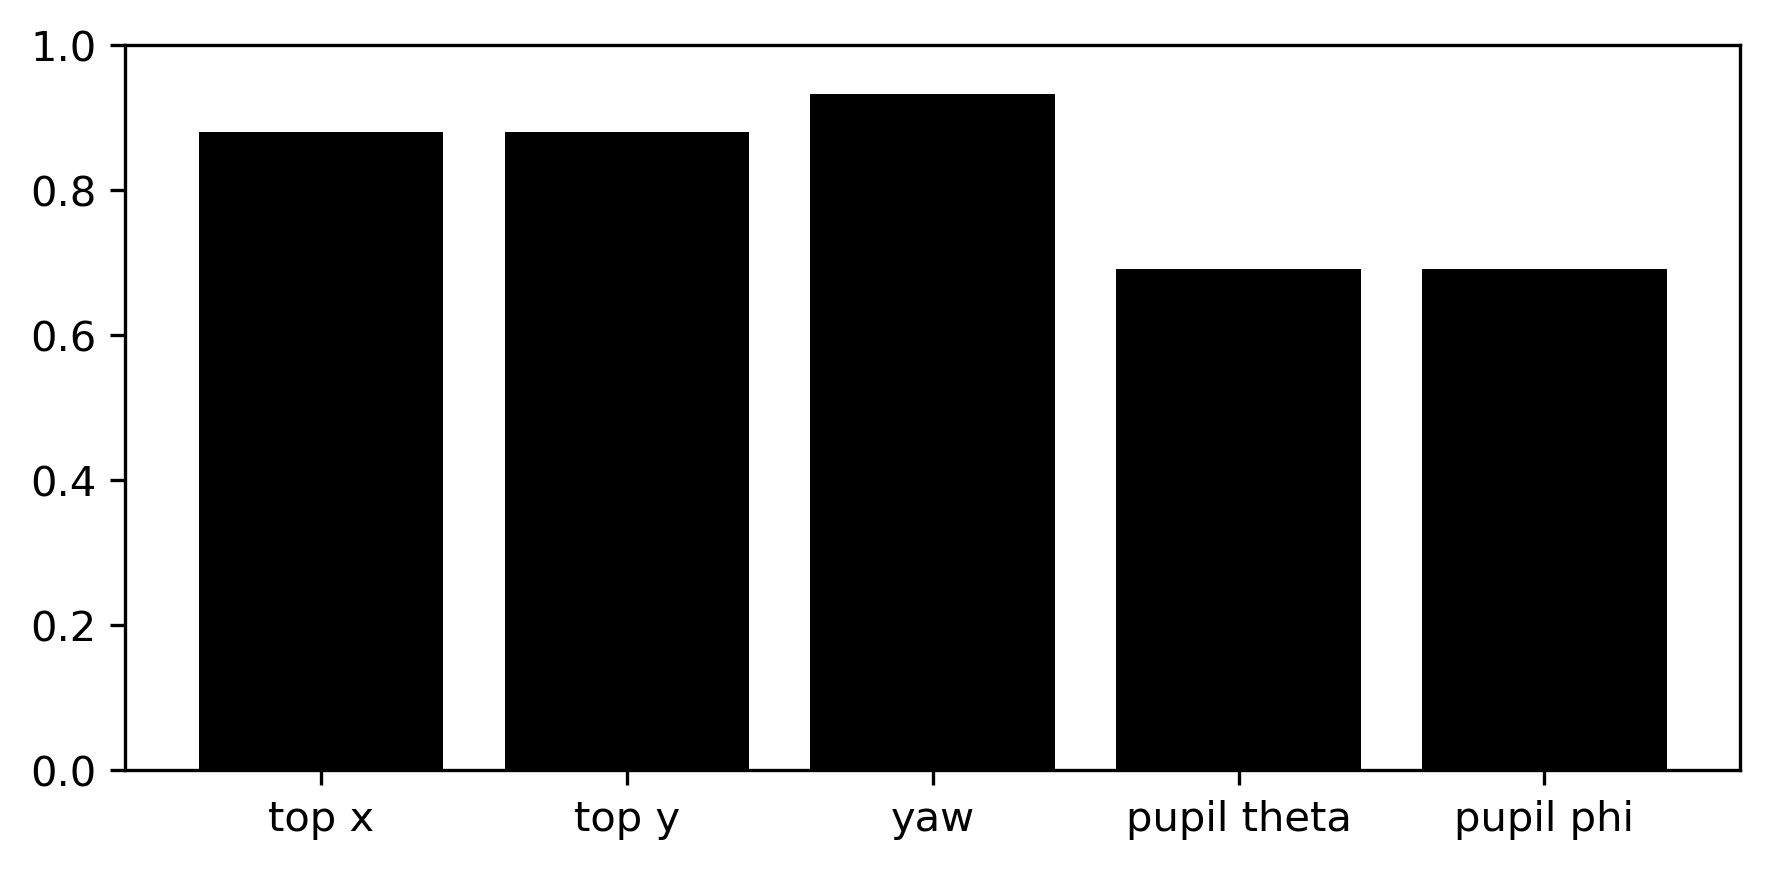

In [116]:
fig, ax = plt.subplots(1,1, dpi=300, figsize=(6,3))
ax.bar(0, frac_good(top_x), color='k')
ax.bar(1, frac_good(top_y), color='k')
ax.bar(2, frac_good(yaw), color='k')
ax.bar(3, frac_good(theta), color='k')
ax.bar(4, frac_good(phi), color='k')
ax.set_xticks(range(5), labels=[
    'top x',
    'top y',
    'yaw',
    'pupil theta',
    'pupil phi'
])
ax.set_ylim([0,1])
fig.tight_layout()

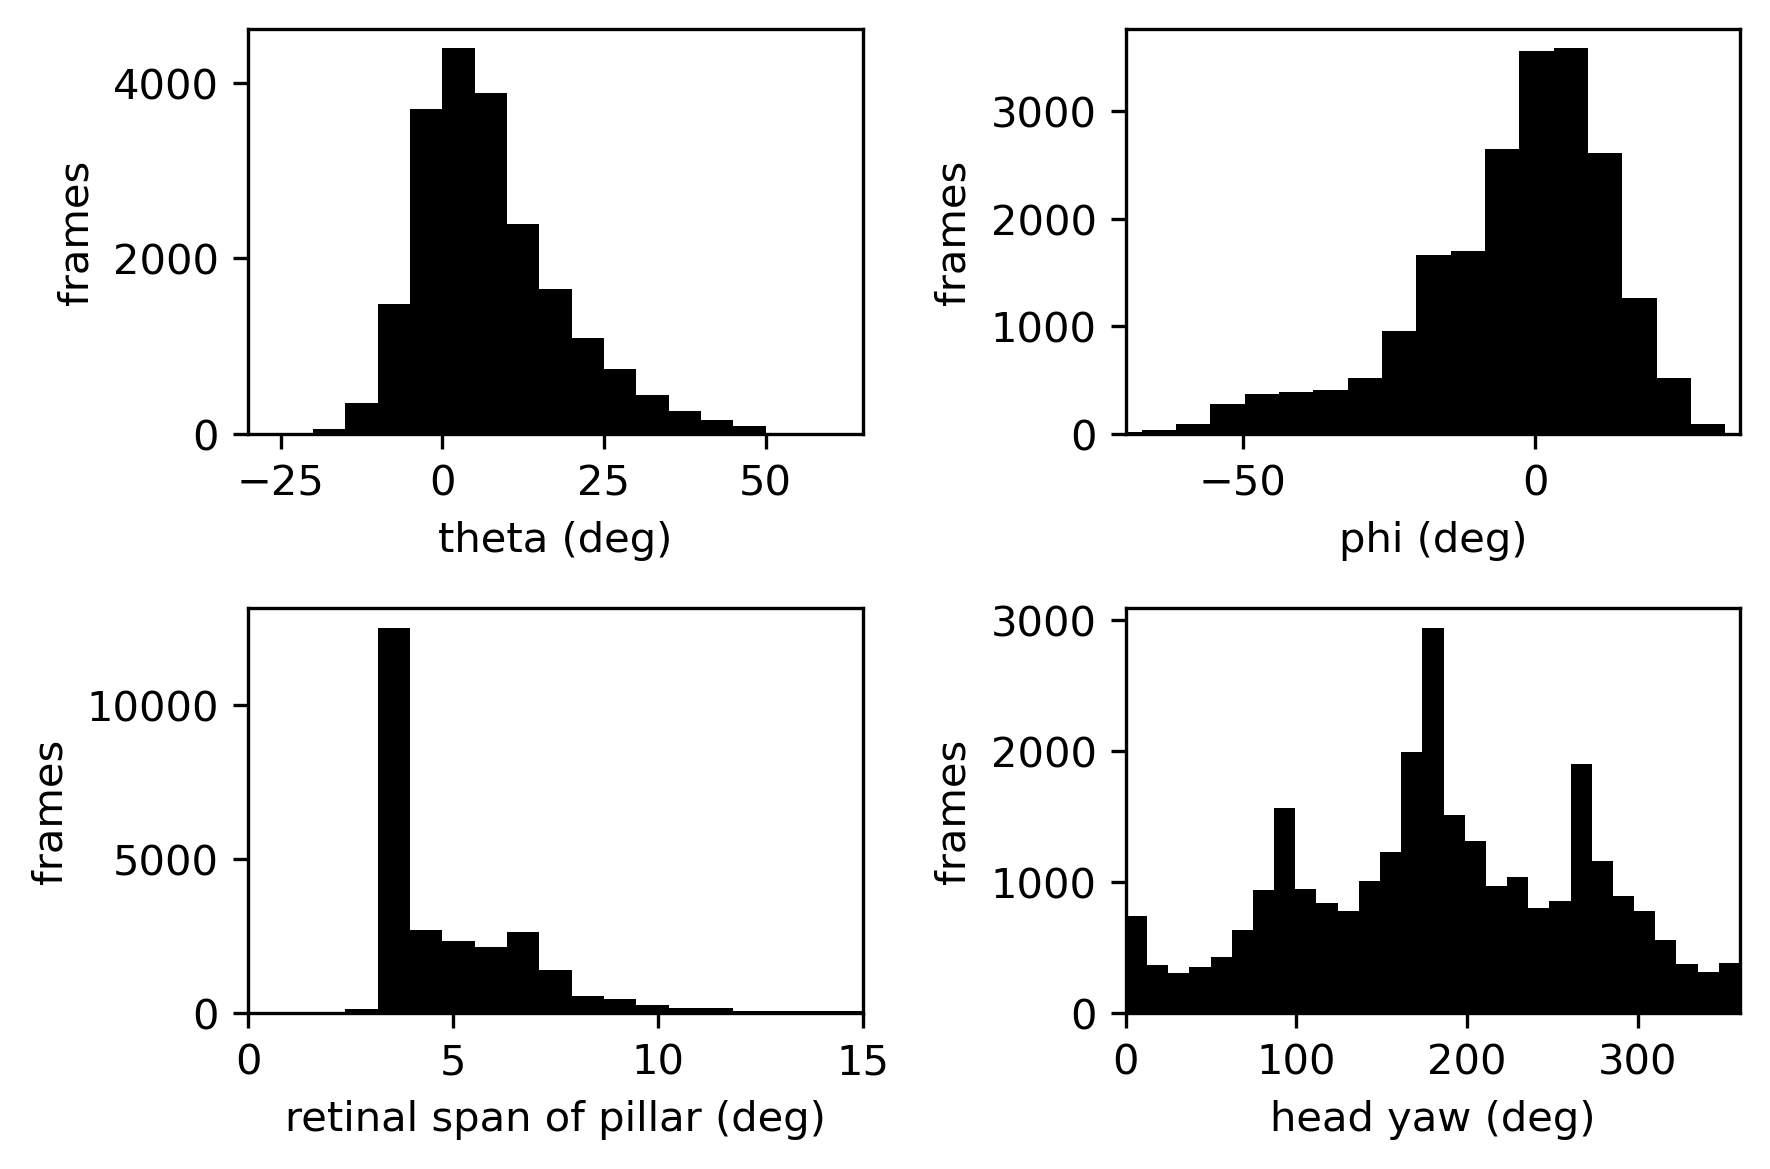

In [100]:
fig, axs = plt.subplots(2, 2, figsize=(6,4), dpi=300)
axs = axs.flatten()
axs[0].hist(np.rad2deg(theta), bins=np.linspace(-30,65,20), color='k')
axs[0].set_xlim([-30, 65])
axs[0].set_xlabel('theta (deg)')
axs[0].set_ylabel('frames')

axs[1].hist(np.rad2deg(phi), bins=20, color='k')
axs[1].set_xlim([-70,35])
axs[1].set_xlabel('phi (deg)')
axs[1].set_ylabel('frames')

axs[2].hist(np.rad2deg(angle_pillar_spans), bins=np.linspace(0, 15, 20), color='k')
axs[2].set_xlim([0,15])
axs[2].set_xlabel('retinal span of pillar (deg)')
axs[2].set_ylabel('frames')

axs[3].hist(yaw, bins=np.linspace(0, 360, 30), color='k')
axs[3].set_xlim([0,360])
axs[3].set_xlabel('head yaw (deg)')
axs[3].set_ylabel('frames')

fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(6,4), dpi=300)
axs = axs.flatten()
axs[0].hist(dist_to_pillar / pxls2cm, bins=20, color='k')
axs[0].set_xlim([0, np.nanmax(dist_to_pillar / pxls2cm)])
axs[0].set_xlabel('theta (deg)')
axs[0].set_ylabel('frames')

axs[1].hist(np.rad2deg(angle_to_pillar)%360, bins=np.linspace(0, 360, 30), color='k')
axs[1].set_xlim([0,360])
axs[1].set_xlabel('phi (deg)')
axs[1].set_ylabel('frames')

# axs[2].hist(np.rad2deg(angle_pillar_spans), bins=np.linspace(0, 15, 20), color='k')
# axs[2].set_xlim([0,15])
# axs[2].set_xlabel('retinal span of pillar (deg)')
# axs[2].set_ylabel('frames')

# axs[3].hist(yaw, bins=np.linspace(0, 360, 30), color='k')
# axs[3].set_xlim([0,360])
# axs[3].set_xlabel('head yaw (deg)')
# axs[3].set_ylabel('frames')

fig.tight_layout()

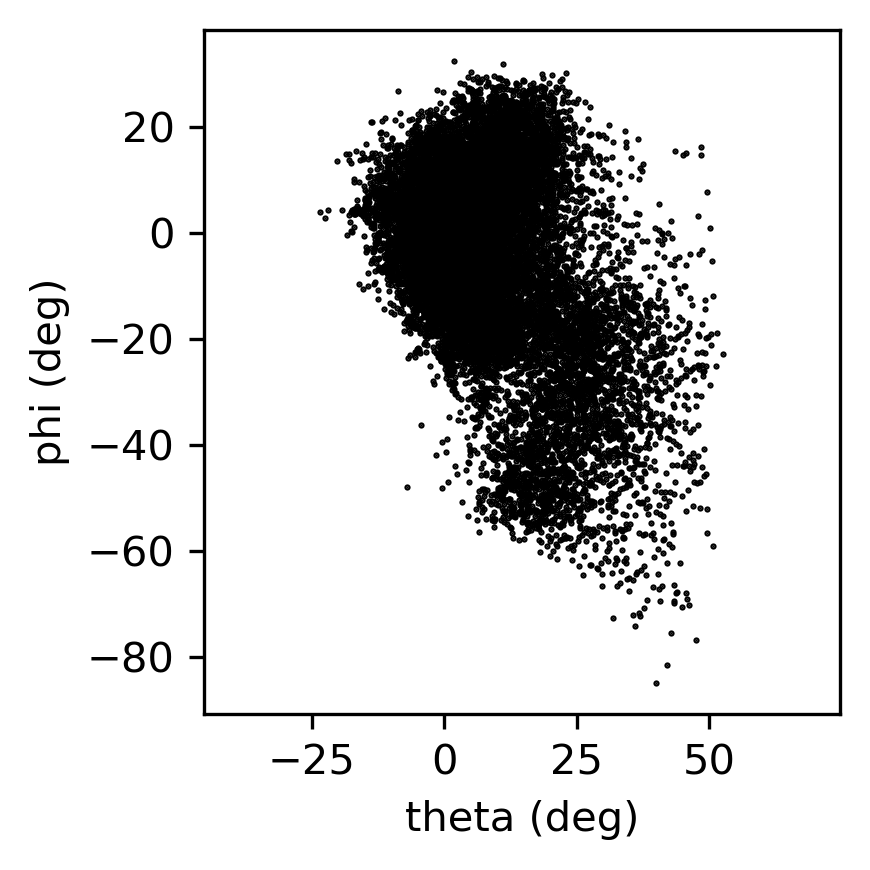

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(3,3), dpi=300)
ax.plot(np.rad2deg(theta), np.rad2deg(phi), 'k.', ms=1)
ax.set_xlabel('theta (deg)')
ax.set_ylabel('phi (deg)')
ax.axis('equal')
fig.tight_layout()

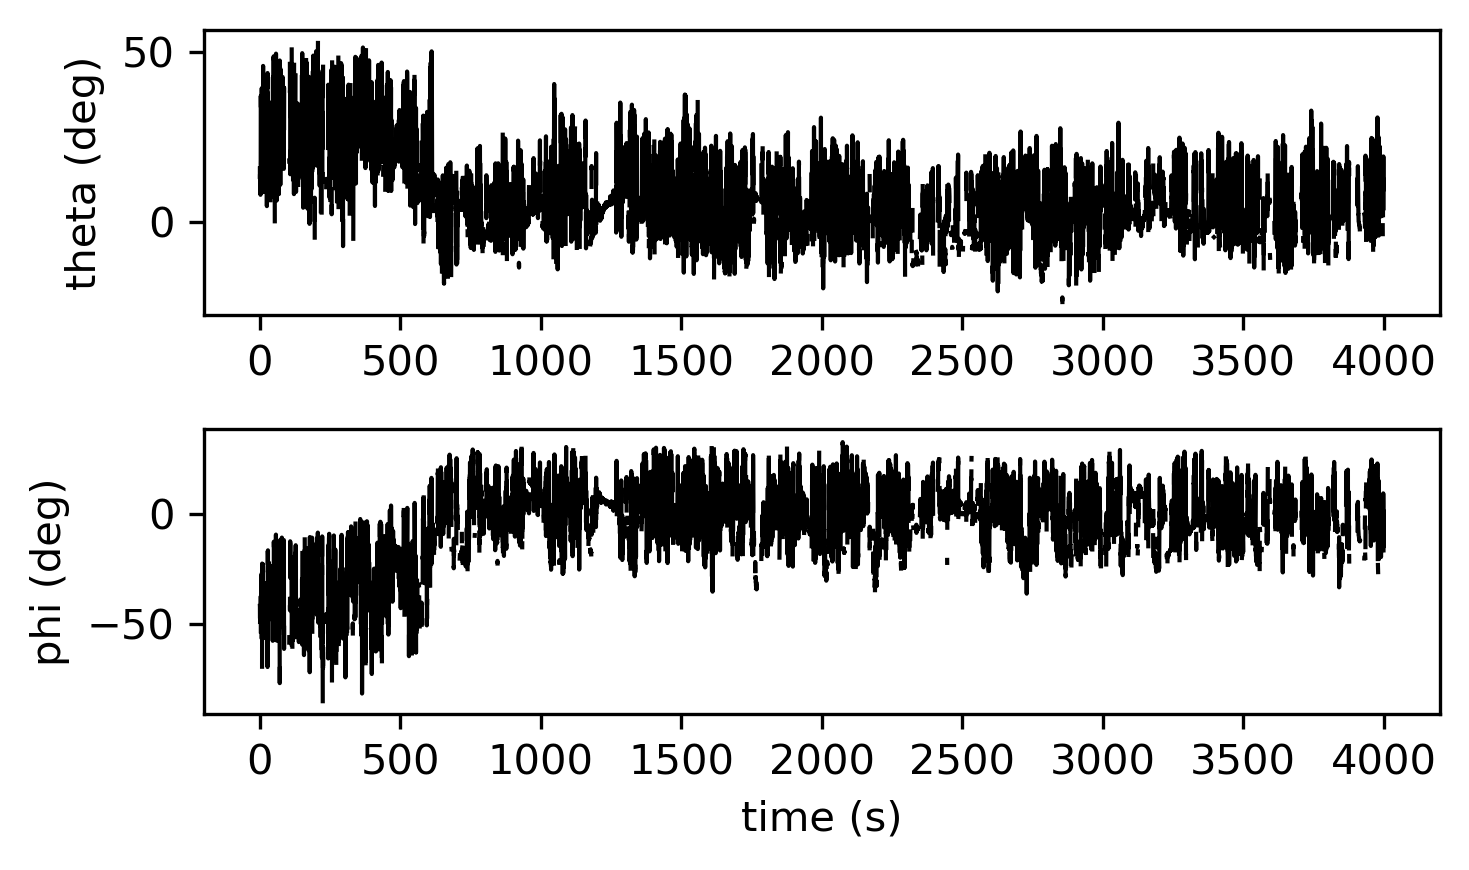

In [132]:
fig, [ax1,ax2] = plt.subplots(2,1, dpi=300, figsize=(5,3))
ax1.plot(twopT, np.rad2deg(theta), 'k-', lw=1)
ax2.plot(twopT, np.rad2deg(phi), 'k-', lw=1)
ax1.set_ylabel('theta (deg)')
ax2.set_ylabel('phi (deg)')
ax2.set_xlabel('time (s)')
fig.tight_layout()

In [133]:
600/60

10.0

In [78]:
np.sum(~np.isnan(yaw)) / len(yaw)

0.9313666666666667

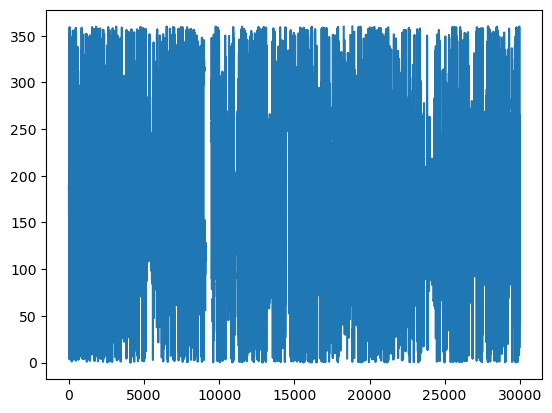

In [79]:
plt.plot(yaw)

(array([ 293.,  526.,  897., 2240., 3894., 2848., 1687., 2735., 8551.,
        2727.]),
 array([  92.91247567,  267.65323452,  442.39399336,  617.13475221,
         791.87551105,  966.6162699 , 1141.35702874, 1316.09778758,
        1490.83854643, 1665.57930527, 1840.32006412]),
 <BarContainer object of 10 artists>)

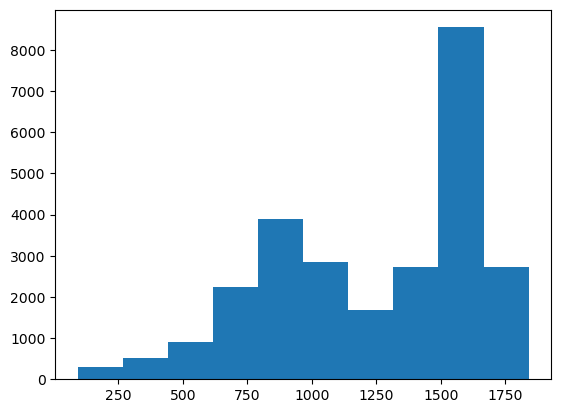

In [8]:
plt.hist(dist_to_pillar)

In [ ]:
plt.figure(dpi=300, figsize=(8,4))
plt.plot(eyeT, theta_raw, lw=1)
plt.plot(twopT, theta+0.5, lw=1)
plt.xlim([3408, 3460])
plt.ylim([-.25,1])

In [ ]:
topdown_video = fm2p.pack_video_frames(r'K:\Mini2P\250220_DMM_DMM042_pillar\fm1\rec2_0001.mp4', dwnsmpl=0.5)

In [ ]:
f = 3410
plt.figure(dpi=300)
plt.imshow(topdown_video[f], cmap='gray')
plt.plot(top_x[f]/2, top_y[f]/2, 'r*')
# plt.arrow(top_x[f]/2, top_y[f]/2, dx= ,dy=)

In [ ]:
plt.hist(yaw)

In [ ]:
# frames = [3410, 2000, 6000, 10000]
frames = [500, 15000, 16000, 17000]

fig, axs = plt.subplots(2,2, dpi=300)
axs = axs.flatten()

for ax in range(4):
    axs[ax].imshow(topdown_video[frames[ax]], cmap='gray')
    axs[ax].set_title('f={} yaw={:.4}'.format(frames[ax], yaw[frames[ax]]))
    axs[ax].plot(top_x[frames[ax]]/2, top_y[frames[ax]]/2, 'r*')
    axs[ax].plot([top_x[frames[ax]]/2, (top_x[frames[ax]]/2)+30*np.cos(np.deg2rad(yaw[frames[ax]]))],
            [top_y[frames[ax]]/2,(top_y[frames[ax]]/2)+30*np.sin(np.deg2rad(yaw[frames[ax]]))],
            '-', linewidth=1, color='cyan')
    axs[ax].plot([top_x[frames[ax]]/2, (top_x[frames[ax]]/2)+30*np.cos(0)],
            [top_y[frames[ax]]/2,(top_y[frames[ax]]/2)+30*np.sin(0)],
            '-', linewidth=1, color='gold')
    
fig.tight_layout()